In [1]:
!pip install opendatasets pandas-profiling scikit-learn --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import opendatasets as od
from ydata_profiling import ProfileReport

In [3]:
resource_url= 'https://www.kaggle.com/competitions/GiveMeSomeCredit/data'

In [4]:
od.download(resource_url)

100%|██████████| 5.16M/5.16M [00:00<00:00, 131MB/s]


Extracting archive ./GiveMeSomeCredit/GiveMeSomeCredit.zip to ./GiveMeSomeCredit


In [5]:
print(f'Current Working Directory: {os.getcwd()}\nChanging the working directory...')
os.chdir('GiveMeSomeCredit')
print(f'New Working Directory: {os.getcwd()}')

Current Working Directory: /content
Changing the working directory...
New Working Directory: /content/GiveMeSomeCredit


In [6]:
data_dictionary= pd.read_excel('Data Dictionary.xls')
train_set= pd.read_csv('cs-training.csv')
test_set= pd.read_csv('cs-test.csv')
sample_entry= pd.read_csv('sampleEntry.csv')

In [7]:
input_features= train_set.iloc[:, 2:].columns.to_list()
target_label= train_set.iloc[:, 1].to_frame().columns.to_list()

### Data Profiling:

In [8]:
#data_profiler= ProfileReport(train_set, explorative= True, dark_mode= True)
#data_profiler.to_file('data_profile.html')

In [9]:
#from google.colab import files

#files.download('data_profile.html')

### Data Imputation:

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
input_features_dataframe= train_set[input_features]

In [12]:
input_features_dataframe.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [13]:
input_features_dataframe.NumberOfDependents.median() == input_features_dataframe.NumberOfDependents.mode().values[0]

True

In [14]:
input_features_dataframe.NumberOfDependents.median()

0.0

In [15]:
input_features_dataframe.MonthlyIncome.median()

5400.0

In [16]:
median_imputer= SimpleImputer(strategy= 'median')

In [17]:
imputed_data= median_imputer.fit_transform(input_features_dataframe)

In [18]:
imputed_features_dataframe= pd.DataFrame(data= imputed_data, columns= input_features_dataframe.columns)

In [19]:
imputed_features_dataframe.isna().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Train and Validation Set Spilt:

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x= imputed_features_dataframe[input_features]
y= train_set[target_label]

In [22]:
x_train, x_validation, y_train, y_validation= train_test_split(x, y.values.ravel(), test_size= 0.25, random_state= 42)

**Note:** *Here .ravel( ) is used for coverting the so that shape of y changes from (n, 1) i.e, a column vector, to (n, ) i.e, a flat array. As scikit-learn often expect the y values to be in the latter form.*

## Machine Learning Modelling:

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Baseline Model:

In [24]:
class ZeroRegressor:
  def __init__(self, zeroes= 0):
    self.zeroes= zeroes
  def predict(self, input_features):
    return np.full(input_features.shape[0], self.zeroes)

In [25]:
baseline_model= ZeroRegressor()

In [26]:
baseline_model_validation_prediction= baseline_model.predict(x_validation)

In [27]:
print(f'ROC-AUC Score of Baseline Model:   {roc_auc_score(y_validation, baseline_model_validation_prediction)}')
print(f'Accuracy Score of Baseline Model:  {round(accuracy_score(y_validation, baseline_model_validation_prediction)*100,3)}%')
print(f'F1 Score of Baseline Model:        {f1_score(y_validation, baseline_model_validation_prediction)}')

ROC-AUC Score of Baseline Model:   0.5
Accuracy Score of Baseline Model:  93.4%
F1 Score of Baseline Model:        0.0


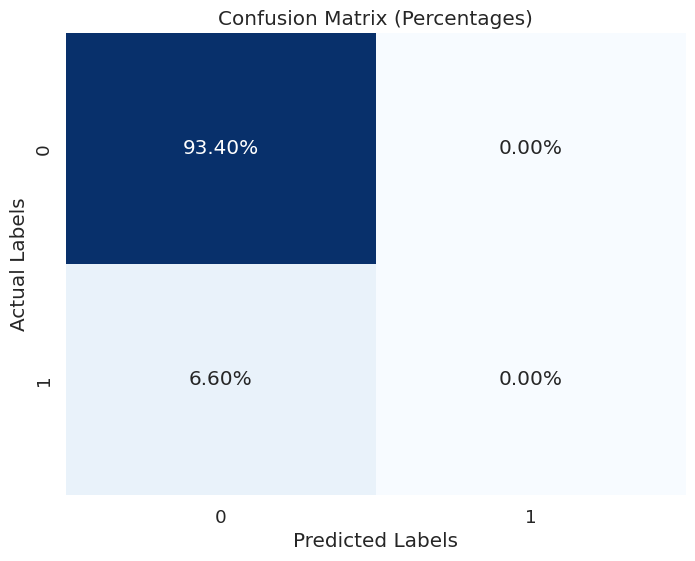

In [28]:
conf_matrix = confusion_matrix(y_validation, baseline_model_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

### Logistic Regression:

In [29]:
from sklearn.linear_model import LogisticRegression

- _In logistic regression, the parameter `C` is the inverse of regularization strength. It is a hyperparameter that determines the amount of regularization applied to the model._

- _Regularization is a technique used in machine learning to prevent overfitting and improve the generalization performance of a model. There are two common types of regularizations used in machine learning, L1 and L2 regularization, often referred to as `Lasso` and `Ridge` regularization._

- _L1 Regularization Model (Lasso):_
  - _L1 regularization adds absolute values of the model's coefficient as a penalty term to the loss function._
  - _It ecourages some of the coefficients to become exactly zero, effectively performing feature selection by removing irrelavent or less important features._
  - _L1 regularization can result in a sparse model with only a subset of features being used for predictions._

- _L2 Regularization Model (Ridge):_
  - _L2 regularization adds the squared values of the models's coefficients as a penalty term to the loss function._
  - _It discourages the model from having very large coefficients, which can help reduce the risk of overfitting._
  - _Unlike L1, L2 regularization typically keeps all features in the model but reduces their influence if they are not essential._

In [30]:
logistic_regression_model= LogisticRegression(C= 1,
                                              max_iter= 1000)

In [31]:
logistic_regression_model.fit(x_train, y_train)

LogisticRegression(C=1, max_iter=1000)

In [34]:
logistic_regression_validation_prediction= logistic_regression_model.predict(x_validation)

In [35]:
print(f'ROC-AUC Score of Logistic Regression Model:   {round(roc_auc_score(y_validation, logistic_regression_validation_prediction), 3)}')
print(f'Accuracy Score of Logistic Regression Model:  {round(accuracy_score(y_validation, logistic_regression_validation_prediction)*100,3)}%')
print(f'F1 Score of Logistic Regression Model:        {round(f1_score(y_validation, logistic_regression_validation_prediction), 3)}')

ROC-AUC Score of Logistic Regression Model:   0.521
Accuracy Score of Logistic Regression Model:  93.403%
F1 Score of Logistic Regression Model:        0.084


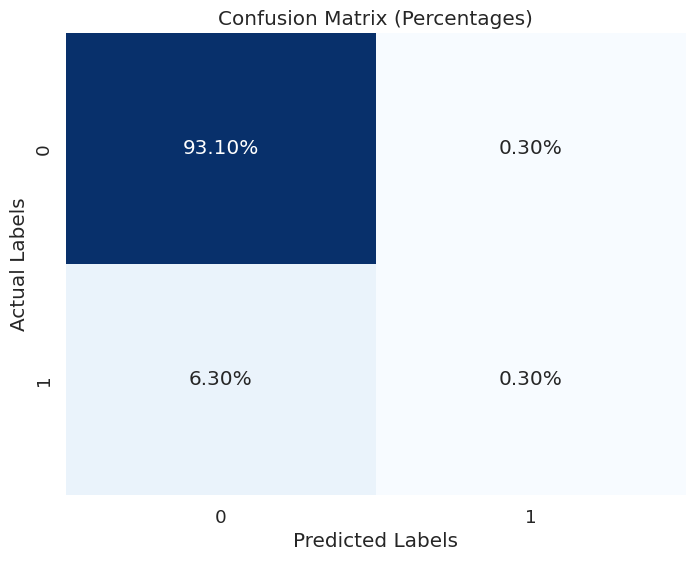

In [113]:
conf_matrix = confusion_matrix(y_validation, logistic_regression_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

### Decision Tree:

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
decision_tree_model= DecisionTreeClassifier(random_state= 42,
                                            criterion= 'gini',
                                            max_depth= 5)

In [52]:
decision_tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [53]:
decision_tree_validation_prediction= decision_tree_model.predict(x_validation)

In [54]:
print(f'ROC-AUC Score of Decision Tree Model:   {round(roc_auc_score(y_validation, decision_tree_validation_prediction), 3)}')
print(f'Accuracy Score of Decision Tree Model:  {round(accuracy_score(y_validation, decision_tree_validation_prediction)*100, 3)}%')
print(f'F1 Score of Decision Tree Model:        {round(f1_score(y_validation, decision_tree_validation_prediction), 3)}')

ROC-AUC Score of Decision Tree Model:   0.591
Accuracy Score of Decision Tree Model:  93.651%
F1 Score of Decision Tree Model:        0.285


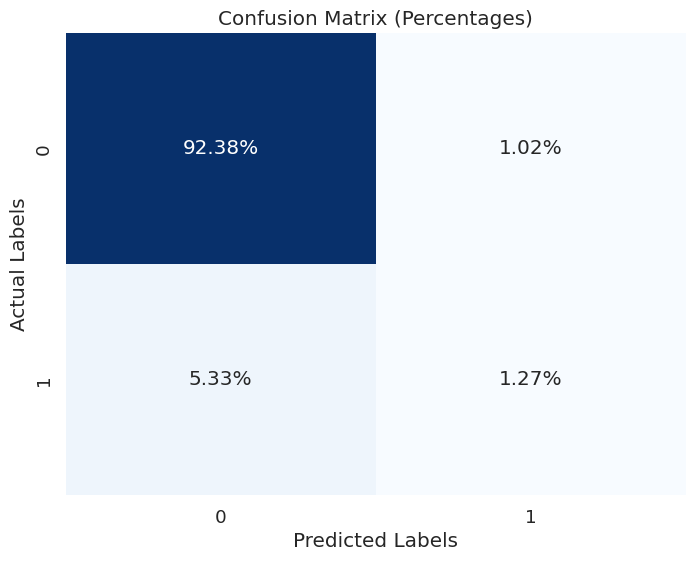

In [114]:
conf_matrix = confusion_matrix(y_validation, decision_tree_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

### Random Forest Classifier:

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
random_forest_model= RandomForestClassifier(criterion= 'gini',
                                            n_estimators= 107,
                                            max_depth= 25,
                                            min_samples_split= 10,
                                            min_samples_leaf= 15,
                                            random_state= 42)

In [57]:
random_forest_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=15, min_samples_split=10,
                       n_estimators=107, random_state=42)

In [58]:
random_forest_validation_prediction= random_forest_model.predict(x_validation)

In [59]:
print(f'ROC-AUC Score of Random Forest Model:   {round(roc_auc_score(y_validation, random_forest_validation_prediction), 3)}')
print(f'Accuracy Score of Random Forest Model:  {round(accuracy_score(y_validation, random_forest_validation_prediction)*100, 3)}%')
print(f'F1 Score of Random Forest Model:        {round(f1_score(y_validation, random_forest_validation_prediction), 3)}')

ROC-AUC Score of Random Forest Model:   0.583
Accuracy Score of Random Forest Model:  93.792%
F1 Score of Random Forest Model:        0.27


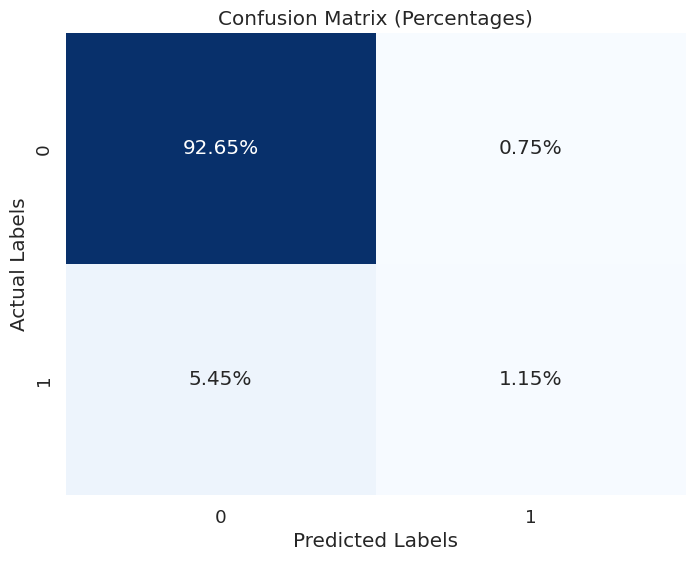

In [115]:
conf_matrix = confusion_matrix(y_validation, random_forest_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

### LightGBM:

In [36]:
import lightgbm as lgb

In [37]:
lgbm_classifier_model= lgb.LGBMClassifier(boosting_type= 'gbdt',
                                          num_leaves= 11,
                                          min_child_samples= 10,
                                          min_child_weight= 10,
                                          colsample_bytree= 0.15,
                                          reg_alpha= 0.25,
                                          reg_lambda= 0.35,
                                          force_col_wise= True)

In [84]:
lgbm_classifier_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 7551, number of negative: 104949
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 112500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067120 -> initscore=-2.631795
[LightGBM] [Info] Start training from score -2.631795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.15, force_col_wise=True, min_child_samples=10,
               min_child_weight=10, num_leaves=11, reg_alpha=0.25,
               reg_lambda=0.35)

In [85]:
lgbm_classifier_validation_prediction= lgbm_classifier_model.predict(x_validation)

In [86]:
print(f'ROC-AUC Score of LightGBM Classifier Model:   {round(roc_auc_score(y_validation, lgbm_classifier_validation_prediction), 3)}')
print(f'Accuracy Score of LightGBM Classifier Model:  {round(accuracy_score(y_validation, lgbm_classifier_validation_prediction)*100, 3)}%')
print(f'F1 Score of LightGBM Classifier Model:        {round(f1_score(y_validation, lgbm_classifier_validation_prediction), 3)}')

ROC-AUC Score of LightGBM Classifier Model:   0.6
Accuracy Score of LightGBM Classifier Model:  93.867%
F1 Score of LightGBM Classifier Model:        0.311


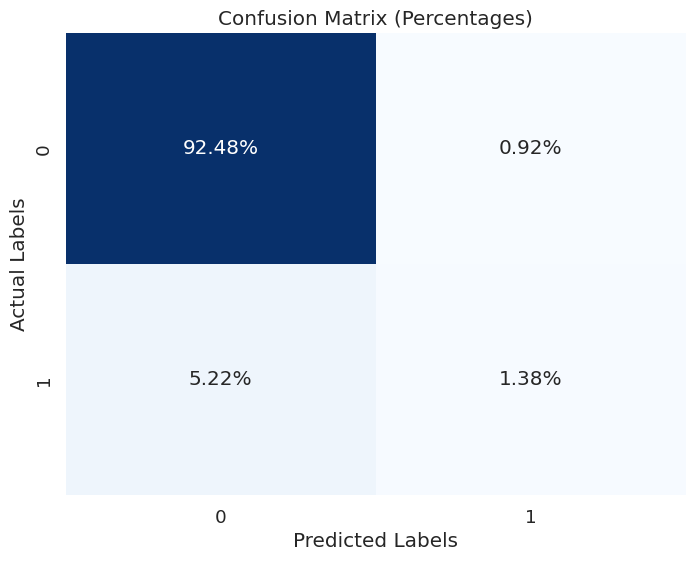

In [116]:
conf_matrix = confusion_matrix(y_validation, lgbm_classifier_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

### Support Vector Machine:

In [87]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [88]:
standard_scaler= StandardScaler()
min_max_scaler= MinMaxScaler()

In [89]:
scaled_x_train_data= min_max_scaler.fit_transform(x_train)
scaled_x_validation_data= min_max_scaler.fit_transform(x_validation)

In [90]:
scaled_x_train= pd.DataFrame(data= scaled_x_train_data, columns= x_train.columns)
scaled_x_validation= pd.DataFrame(data= scaled_x_validation_data, columns= x_validation.columns)

_SVM has two types of kernels:_
- __Linear:__
  - _The linear kernel is a simple, linear transformation of the input data._
  - _It works well when the data is linearly separabel, meaning we can draw a straight line or hyperplane to separate the class._
  - _Linear kernels are computationally efficient and work well when the relationship between features and target variable is approximately linear._

- __RBF (Radial Basis Function):__
  - _The RBF kernel is a non-linear kernel that can model complex relationships between data points._
  - _It maps the data into a higher-dimensional space where it becomes more separable by a hyperplane._
  - _The RBF is  particularly useful when the data is not linearly separable in the original feature space._
  - _The RBF kernel introduces a hyperparameter called gamma(_ $\gamma$ _) that can control the shape and felxibility of the decision boundary. Higher values of gamma lead to a more complex decision boundary, which can  potentially overfit the data._

In [91]:
svm_model= svm.SVC(kernel= 'rbf',
                   max_iter= 7500,
                   C= 0.005)

In [92]:
svm_model.fit(scaled_x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.005, max_iter=7500)

In [97]:
svm_classifier_validation_prediction= svm_model.predict(scaled_x_validation)

In [98]:
print(f'ROC-AUC Score of SVM Classifier Model:   {round(roc_auc_score(y_validation, svm_classifier_validation_prediction), 3)}')
print(f'Accuracy Score of SVM Classifier Model:  {round(accuracy_score(y_validation, svm_classifier_validation_prediction)*100, 3)}%')
print(f'F1 Score of SVM Classifier Model:        {round(f1_score(y_validation, svm_classifier_validation_prediction), 3)}')

ROC-AUC Score of SVM Classifier Model:   0.566
Accuracy Score of SVM Classifier Model:  93.613%
F1 Score of SVM Classifier Model:        0.225


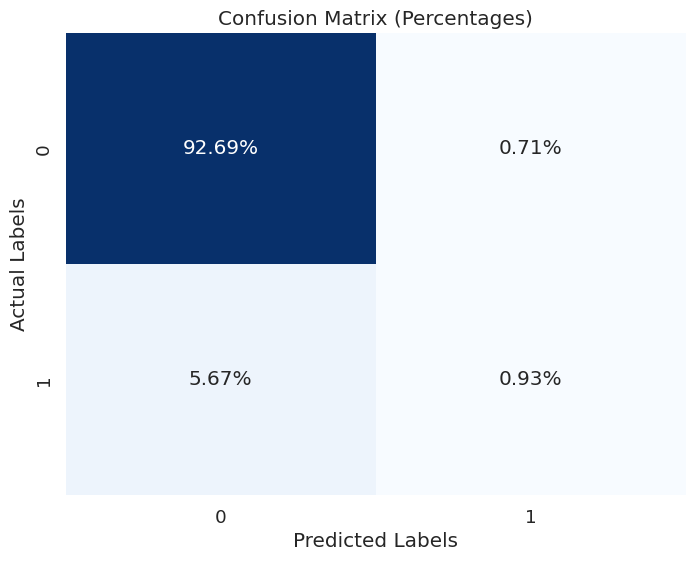

In [117]:
conf_matrix = confusion_matrix(y_validation, svm_classifier_validation_prediction)

# Normalizing the confusion matrix to percentages with respect to the entire matrix
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum().sum()

# Creating a heatmap for the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

## Observations:

- Decision Tree:
  - Hyperparameter:
    - criterion= gini
    - max_depth= 5
  - Accuracy Score: 93.651%
  - ROC-AUC: 0.591

- Random Forest Classifier:
  - Hyperparameter:
    - criterion= gini
    - n_estimators= 107
    - max_depth= 25
    - min_samples_split= 10
    - min_samples_leaf= 15
  - Accuracy Score: 93.792%
  - ROC-AUC: 0.583

- LightGBM:
  - Hyperparameter:
    - boosting_type= gbdt
    - num_leaves= 11
    - min_child_samples= 10
    - min_child_weight= 10
    - colsample_bytree= 0.15
    - reg_alpha= 0.25
    - reg_lambda= 0.35
    - force_col_wise= True
  - Accuracy Score: 93.867%
  - ROC-AUC: 0.6

- SVM:
  - Hyperparameter:
    - kernel= rbf
    - max_iter= 7500
    - C= 0.005
  - Accuracy Score: 93.613%
  - ROC-AUC: 0.566


## Final Model:

In [38]:
final_x= imputed_features_dataframe[input_features]
final_y= train_set[target_label]

In [39]:
lgbm_classifier_model.fit(final_x, final_y.values.ravel())

[LightGBM] [Info] Number of positive: 10026, number of negative: 139974
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066840 -> initscore=-2.636275
[LightGBM] [Info] Start training from score -2.636275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.15, force_col_wise=True, min_child_samples=10,
               min_child_weight=10, num_leaves=11, reg_alpha=0.25,
               reg_lambda=0.35)

In [40]:
test_set_input_features= test_set.iloc[:, 2:]

In [41]:
imputed_test_data= median_imputer.fit_transform(test_set_input_features)
imputed_test_features_dataframe= pd.DataFrame(data= imputed_test_data, columns= test_set_input_features.columns)

In [42]:
final_model_prediction= lgbm_classifier_model.predict_proba(imputed_test_features_dataframe)

In [54]:
zero_probability= [final_model_prediction[x, 1] for x in range(final_model_prediction.shape[0])]

In [65]:
result_dataframe= test_set.iloc[:, 0].to_frame()
result_dataframe.columns = ['Id']
result_dataframe['Probability']= zero_probability.copy()

result_dataframe.set_index('Id', inplace= True)

In [66]:
result_dataframe

,Probability
Id,
1,0.071806
2,0.059174
3,0.016880
4,0.076928
5,0.088666
...,...
101499,0.035242
101500,0.315341
101501,0.009404


In [67]:
result_dataframe.to_csv('probability_prediction.csv')

In [68]:
pd.read_csv('probability_prediction.csv')

,Id,Probability
0,1,0.071806
1,2,0.059174
2,3,0.016880
3,4,0.076928
4,5,0.088666
...,...,...
101498,101499,0.035242
101499,101500,0.315341
101500,101501,0.009404
101501,101502,0.084311
